In [1]:
import os
import numpy as np
import pandas as pd
from compute_tempo import *
import matplotlib.pyplot as plt
from mutils import DataHandler
from scipy.signal import find_peaks
from fautocorrelation import *

Loaded BKO_E1_D1_08_Suku_T.pkl
Error encountered for: Group 'gr' not found in the dataset.
Loaded BKO_E3_D5_03_Wasulunka_T.pkl
Total Sections: 1
114.2032818416782


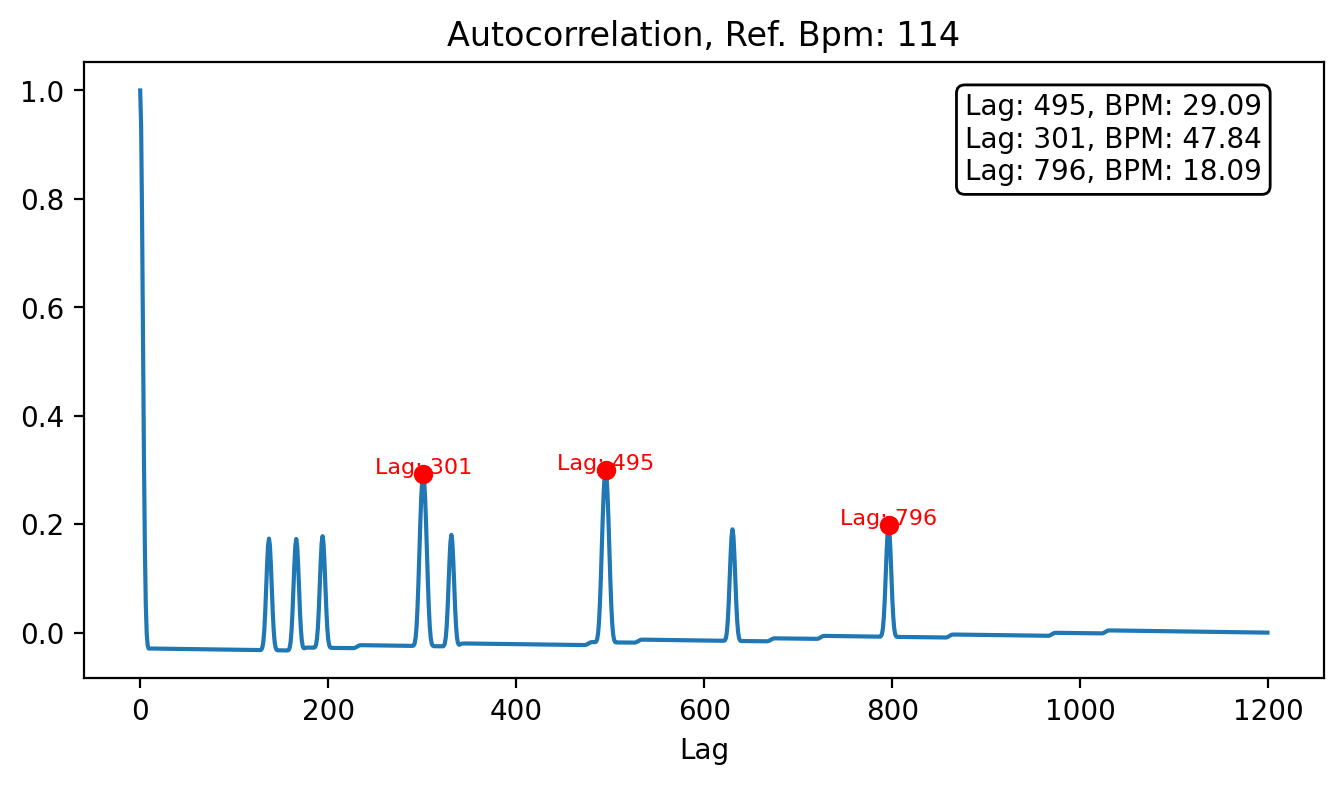

Loaded BKO_E2_D4_05_Sandia_T.pkl
Total Sections: 1
91.98453195432808


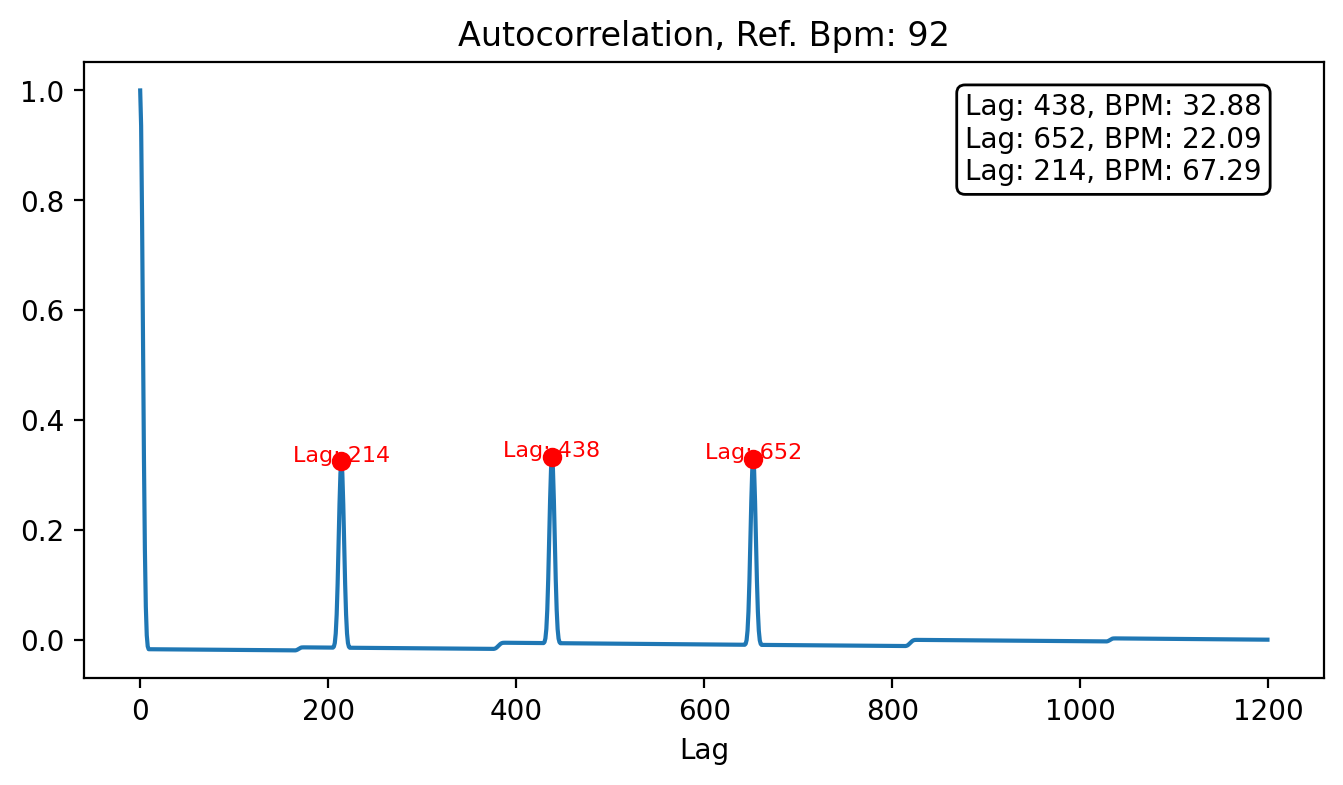

Loaded BKO_E2_D4_01_Suku_T.pkl
Total Sections: 1
128.83789500673035


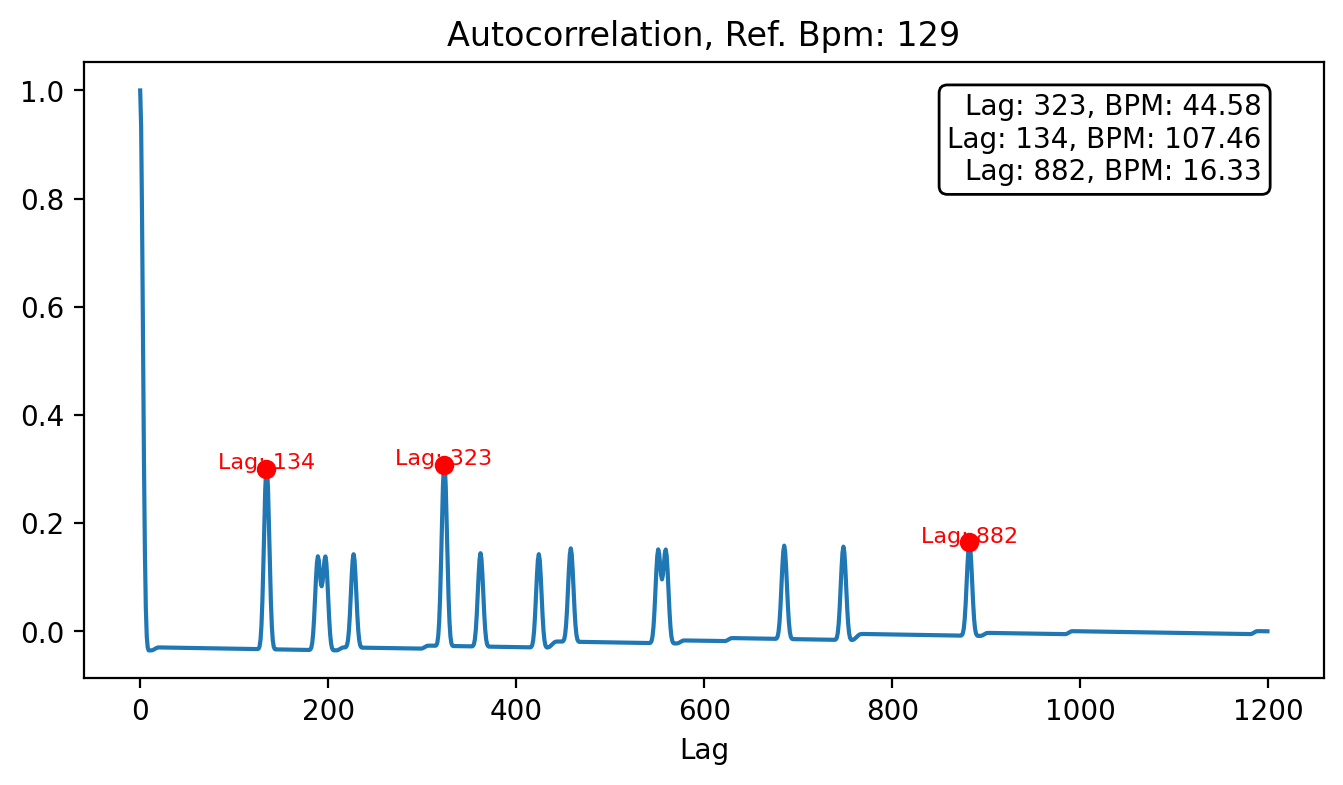

In [5]:
# SEGMENT_HEAD  SEGMENT_PELVIS   SEGMENT_T8  SEGMENT_LEFT_HAND  SEGMENT_LEFT_FOOT
pkl_filelist = os.listdir(f"/itf-fi-ml/home/sagardu/djembe_drive/sgr_pyspace/Dataset_V2")
data_handler = DataHandler()

for i, filename in enumerate(pkl_filelist):

    filename = filename.replace("_Dancers.csv", "_T.mvnx")
    piece_name = os.path.basename(filename).split(".")[0]
    try:
        motion_data, drum_onsets, start_f, end_f, start_t, end_t, cycle_onsets, beat_ref, bpm = data_handler.load_and_process_data(filename, mode = 'gr', drum = 'J2', section_idx=0)
    except ValueError as e:
        # Handle the error and continue
        print(f"Error encountered for: {e}")
        continue


    duration = int(end_t-start_t)
    w_sec = int(duration)
    h_sec = int(w_sec/3)
    
    mocap_fps = 240
    window_size = int(240*w_sec)
    hop_size = int(240*h_sec)
    tempi_range = np.arange(50,150,1)

    sensorA_velocity = motion_data['velocity']["SEGMENT_LEFT_FOOT"]         # [start_f:end_f]
    sensorA_position = motion_data['position']["SEGMENT_LEFT_FOOT"]         # [start_f:end_f]
    
    sensorA_velocity_norm = z_score_normalize(sensorA_velocity)
    sensorA_position_norm = z_score_normalize(sensorA_position)
    
    sensor_pos_axes = smooth_velocity(sensorA_position_norm, abs='no')                     # size (n, 3)
    sensorA_positiond= detrend_signal_array(sensor_pos_axes, cutoff= 0.8)
    
    zero_uni_onsets, zero_bi_onsets = get_zero_onsets(sensorA_velocity_norm, sensorA_positiond, 
                                                  distance_threshold=0.015,tcut= 0.5, vel_thres = 0.05,)
    ax=2
    sensorA_vel = zero_bi_onsets[start_f:end_f, ax]

    print(bpm)
    continuous_signal = binary_to_peak(sensorA_vel[:240*5], mocap_fps, peak_duration=0.04)
    autocorr_values = binary_autocorrelation(continuous_signal)
    
    top_peaks = find_top_peaks_scipy(autocorr_values, num_peaks=3)

    # Plot autocorrelation and annotate peaks
    plt.figure(figsize=(8, 4), dpi=200)
    plt.plot(autocorr_values)

    for lag, peak_value in top_peaks:
        plt.plot(lag, peak_value, 'ro')  # Mark peaks
        plt.text(lag, peak_value, f'Lag: {lag}', fontsize=8, color='red', ha='center')

    # Add a summary text box for lag values
    lag_text = "\n".join([f'Lag: {lag}, BPM: {np.round((240 * 60) / lag, 2)}' for lag, _ in top_peaks])
    plt.gca().text(0.95, 0.95, lag_text, fontsize=10, color='black',
                ha='right', va='top', transform=plt.gca().transAxes,
                bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))

    plt.xlabel('Lag')
    plt.title(f'Autocorrelation, Ref. Bpm: {round(bpm)}')
    # plt.legend()
    plt.show()
    
    if i == 3:
        break

In [ ]:
continuous_signal = binary_to_peak(sensorA_vel[:240*5], mocap_fps, peak_duration=0.04)

# Plot the result
plt.figure(figsize=(10, 4))
plt.plot(continuous_signal, label='Peak Representation')
# plt.stem(sensorA_vel, linefmt='r--', markerfmt='ro', basefmt=' ', label='Binary Array')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.title('Binary Array Represented by 50ms Bandwidth Peaks')
plt.legend()
plt.show()


In [ ]:
autocorr_values = binary_autocorrelation(continuous_signal)

# Plot the autocorrelation
plt.figure(figsize=(8, 4), dpi=200)
plt.plot(autocorr_values, label='Autocorrelation', linewidth=0.3)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation of Binary Array')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.3)
plt.legend()
plt.show()


In [ ]:
# Get top 5 peaks
top_peaks = find_top_peaks_scipy(autocorr_values, num_peaks=3)

# Plot autocorrelation and annotate peaks
plt.figure(figsize=(8, 4), dpi=200)
plt.plot(autocorr_values)

for lag, peak_value in top_peaks:
    plt.plot(lag, peak_value, 'ro')  # Mark peaks
    plt.text(lag, peak_value, f'Lag: {lag}', fontsize=8, color='red', ha='center')

# Add a summary text box for lag values
lag_text = "\n".join([f'Lag: {lag}, BPM: {np.round((240 * 60) / lag, 2)}' for lag, _ in top_peaks])
plt.gca().text(0.95, 0.95, lag_text, fontsize=10, color='black',
               ha='right', va='top', transform=plt.gca().transAxes,
               bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))

plt.xlabel('Lag')
plt.title(f'Autocorrelation, Ref. Bpm: {round(bpm)}')
# plt.legend()
plt.show()


print(f"Music BPM: {np.round(bpm,2)}")
for lag, peak_value in top_peaks:
    print(f"Lag: {lag}, BPM: {np.round((mocap_fps * 60) / lag, 2)}")
